## TS plots and linear relationship

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cmocean
import matplotlib.dates as mdates
import cmocean
import gsw
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib import gridspec

In [2]:
# open Sverdrup 2019 dataset
file_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
sverdrup_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_L3_2018-2019.nc")
sverdrup_ds.close()

In [3]:
# open Rink 2019 dataset
file_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
rink_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_RinkFisher_1D_L3_2018-2019.nc")
rink_ds.close()

In [4]:
# open Fisher Islands 2020 dataset
file_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
fisher_ds = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_RinkFisher_1D_L3_2019-2020.nc')
fisher_ds.close()

In [5]:
# open Kong Oscar 2019 dataset
file_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
kongoscar19 = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar_1D_L3_2018-2019.nc")
kongoscar19.close()

In [6]:
# open Kong Oscar 2020 dataset
file_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
kongoscar20 = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_KongOscar_1D_L3_2019-2020.nc')
kongoscar20.close()

***

In [7]:
# function to convert Absolute Salinity from Practical Salinity and Conservative Temperature from in-situ temperature
def convert_to_teos10(ds):
    # absolute salinity
    SA = gsw.conversions.SA_from_SP(ds.salinity,ds.pressure,ds.longitude,ds.latitude)
    # conservative temp
    CT = gsw.conversions.CT_from_t(SA,ds.temperature,ds.pressure)

    SA = SA.isel(station=0)
    CT = CT.isel(station=0)
    
    return SA, CT

In [8]:
# for all moorings: convert Absolute Salinity from Practical Salinity and Conservative Temperature from in-situ temperature
sverdrup_SA, sverdrup_CT = convert_to_teos10(sverdrup_ds)
rink_SA, rink_CT = convert_to_teos10(rink_ds)
fisher_SA, fisher_CT = convert_to_teos10(fisher_ds)
kongoscar19_SA, kongoscar19_CT = convert_to_teos10(kongoscar19)
kongoscar20_SA, kongoscar20_CT = convert_to_teos10(kongoscar20)

In [9]:
# convert to conservative temperature and absolute salinity
sverdrup_ds['potential_temperature'] = sverdrup_CT
sverdrup_ds['salinity'] = sverdrup_SA

rink_ds['potential_temperature'] = rink_CT
rink_ds['salinity'] = rink_SA

fisher_ds['potential_temperature'] = fisher_CT
fisher_ds['salinity'] = fisher_SA

kongoscar19['potential_temperature'] = kongoscar19_CT
kongoscar19['salinity'] = kongoscar19_SA

kongoscar20['potential_temperature'] = kongoscar20_CT
kongoscar20['salinity'] = kongoscar20_SA

***

Function that calculates density grid using temperature and salinity data (for density contours of TS plot)

In [10]:
def sigma_theta_grid(theta_ds, salt_ds):
    min_theta = theta_ds.min()
    max_theta = theta_ds.max()
    min_salt  = salt_ds.min()
    max_salt  = salt_ds.max()
    
    theta_vals = np.linspace(min_theta-0.5, max_theta+0.5, 156)
    salt_vals  = np.linspace(min_salt-0.05, max_salt+0.05, 156)
    
    Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
    sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)
    
    return salt_vals, theta_vals, sigma_theta_2d

In [11]:
def plot_TS(mooring_ds, savefig=True):
    
    # extract pot temp and salinity data
    salt_ds = mooring_ds.salinity
    theta_ds = mooring_ds.potential_temperature.sel(depth_CTD=salt_ds.depth_CTD.values)
    # calculate dentisy grid
    salt_vals, theta_vals, sigma_theta_2d = sigma_theta_grid(theta_ds, salt_ds)
    # extract times
    dates = theta_ds.time.values
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.depth_CTD.values.max()
    
    # PLOT -------------------------------------------------------
    plt.figure(figsize=[6.5,5]);
    
    # # ctd data
    # for i in range(len(sver_ctd_ship_18.profile)):
    #     plt.plot(sver_ctd_ship_18.salinity.isel(profile=i), sver_ctd_ship_18.potential_temperature.isel(profile=i),c='k',linewidth=0.6, zorder=1)
    # for i in range(len(sver_ctd_ship_19.profile)):
    #     plt.plot(sver_ctd_ship_19.salinity.isel(profile=i), sver_ctd_ship_19.potential_temperature.isel(profile=i),c='k',linewidth=0.6, zorder=1)
    
    # plot density contour
    cs = plt.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.2),linewidths=0.5,zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=True, fmt='%.1f')
    
    # mooring data
    colors = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    plt.scatter(salt_ds.sel(depth_CTD=ctd_depth_shallow),theta_ds.sel(depth_CTD=ctd_depth_shallow),\
                c=mdates.date2num(dates), s=40, edgecolor='k',linewidth=0.4,\
                cmap=colors,label=str(ctd_depth_shallow)+'m')
    pts = plt.scatter(salt_ds.sel(depth_CTD=ctd_depth_deep),theta_ds.sel(depth_CTD=ctd_depth_deep),\
                      c=mdates.date2num(dates),s=50, marker='^',edgecolor='k',linewidth=0.4,\
                      cmap=colors,label=str(ctd_depth_deep)+'m')
    cb = plt.colorbar(pts)
    cb.ax.set_title("      Month")
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    # plot params
    # plt.ylim(-1,2)
    # plt.xlim(33,34.5)
    
    plt.ylabel('$\mathit{\Theta}$ (°C)')
    plt.xlabel("Salinity")
    
    # make custom legend
    # custom = [Line2D([], [], marker='o', markersize=6, color='none', markeredgecolor='k',linewidth=0.4,linestyle='None'),\
    #           Line2D([], [], marker='^', markersize=7, color='none', markeredgecolor='k',linewidth=0.4,linestyle='None')]
    plt.legend(loc='lower right')
    
    plt.title('%s mooring' % (mooring_ds.glacier_front[:-8]));
    
    if savefig == True:
        filename = 'ts_' + mooring_ds.glacier_front[:-8]
        plt.savefig("figures/TS_relationship/" + filename + ".png", bbox_inches='tight', dpi=300, facecolor='white');
        
    plt.show();

#### Make multi-panel plots

In [12]:
temp_array = np.concatenate((sverdrup_ds.potential_temperature.values.flatten(),\
                             rink_ds.potential_temperature.values.flatten(),\
                             fisher_ds.potential_temperature.values.flatten(),\
                             kongoscar19.potential_temperature.values.flatten(),\
                             kongoscar20.potential_temperature.values.flatten()))
max_theta = temp_array[~np.isnan(temp_array)].max()
min_theta = temp_array[~np.isnan(temp_array)].min()

In [13]:
salt_array = np.concatenate((sverdrup_ds.salinity.values.flatten(),\
                             rink_ds.salinity.values.flatten(),\
                             fisher_ds.salinity.values.flatten(),\
                             kongoscar19.salinity.values.flatten(),\
                             kongoscar20.salinity.values.flatten()))
max_salt = salt_array[~np.isnan(salt_array)].max()
min_salt = salt_array[~np.isnan(salt_array)].min()

In [70]:
theta_vals = np.linspace(-2, 2.5, 156)
salt_vals  = np.linspace(32.5, 34.7, 156)

Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)

List of mooring datasets:

In [71]:
mooring_data_list = [rink_ds, fisher_ds, kongoscar19, kongoscar20, sverdrup_ds]

***

## Find an expression relating S with T for each mooring

In [16]:
import statsmodels.api as sm

In [17]:
def pred_salt_from_temp_linear_fit(mooring_ds, temp_interp_ds):
    """
    Function to calculate linear fit to March-June mooring CTD observations.
    Then uses linear fit coefficients to predict salinity from interpolated temperature profile.
    Returns coefficients (slope and intercept of line) and predicted salinity values.
    """
    # extract observations taken March-June
    if '2018' in str(mooring_ds.time.values[0]):
        mooring_MarJun_ds = mooring_ds.sel(time=slice('2019-03','2019-06'))
    if '2019' in str(mooring_ds.time.values[0]):
        mooring_MarJun_ds = mooring_ds.sel(time=slice('2020-03','2020-06'))
    
    # assign X and Y for linear fit (we want salinity to be response because we will predict salinity using temp)
    Y = mooring_MarJun_ds.salinity.values.ravel()
    X = sm.add_constant(mooring_MarJun_ds.sel(depth_temperatureerature=mooring_ds.depth_CTD.values).temperature.values.ravel())
    
    # run OLS linear fit
    linmodel = sm.OLS(Y, X)
    results = linmodel.fit()
    linpred = results.predict(X)
    params = results.params
    
    # predict salinity using temperature values and linear fit
    # params is indexed: [intercept, slope]
    salinity_pred_da = params[1]*temp_interp_ds.conservative_temperature + params[0]
    
    # return linear fit and parameters for line (intercept and slope) and predicted salinity values
    return linpred,params,salinity_pred_da

### Predict salinity profile from interpolated temperature data

In [18]:
mooring_interp_path = '/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/OMG_narwhals_mooring_interpolated/'

#### RINK

In [19]:
# load interpolated temp and salinity datasets
rink_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_temp_profile.nc')
rink_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_salt_profile.nc')

In [20]:
linpred, params_rink, rink_salinity_pred = pred_salt_from_temp_linear_fit(rink_ds,rink_temp_interp_ds)

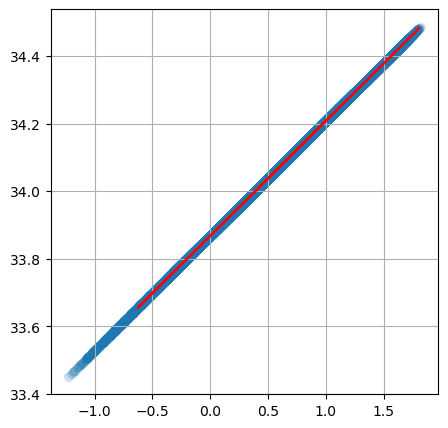

In [21]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(rink_ds.sel(depth_temperatureerature=rink_ds.depth_CTD.values).temperature.sel(time=slice('2019-03','2019-06')).values.ravel(),linpred,c='r')
plt.scatter(rink_temp_interp_ds.conservative_temperature,rink_salinity_pred,alpha=0.1)
plt.grid()

#### FISHER

In [22]:
# load interpolated temp and salinity datasets
fisher_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_temp_profile.nc')
fisher_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_salt_profile.nc')

In [23]:
linpred, params_fish, fisher_salinity_pred = pred_salt_from_temp_linear_fit(fisher_ds,fisher_temp_interp_ds)

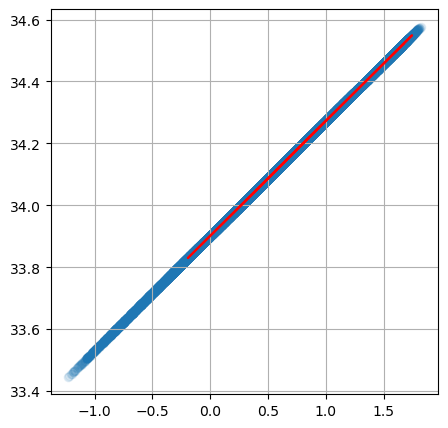

In [24]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(fisher_ds.sel(depth_temperatureerature=fisher_ds.depth_CTD.values).temperature.sel(time=slice('2020-03','2020-06')).values.ravel(),linpred,c='r')
plt.scatter(fisher_temp_interp_ds.conservative_temperature,fisher_salinity_pred,alpha=0.1)
plt.grid()

#### RINK/FISHER

Need to handle Rink/Fisher differently because we have two years worth of data and need to extract March-June from each year (separate datasets)

In [25]:
# load interpolated temp and salinity datasets
rinkfisher_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_temp_profile.nc')
rinkfisher_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_salt_profile.nc')

In [26]:
rinkfisher_ds = xr.concat([rink_ds,fisher_ds],dim="time")

In [27]:
mooring_MarJun_19_ds = rink_ds.sel(time=slice('2019-03','2019-06'))
mooring_MarJun_20_ds = fisher_ds.sel(time=slice('2020-03','2020-06'))
mooring_MarJun_ds = xr.concat([mooring_MarJun_19_ds, mooring_MarJun_20_ds], dim='time')

# assign X and Y for linear fit (we want salinity to be response because we will predict salinity using temp)
yy = mooring_MarJun_ds.salinity.values
xx = mooring_MarJun_ds.sel(depth_temperatureerature=rinkfisher_ds.depth_CTD.values).temperature.values
# drop nans
yy_array = yy[~np.isnan(yy)]
xx_array = xx[~np.isnan(xx)]
# add constant
X = sm.add_constant(xx_array)

In [28]:
# run OLS linear fit
linmodel = sm.OLS(yy_array, X)
results = linmodel.fit()
linpred = results.predict(X)
params_rinkfish = results.params

# predict salinity using temperature values and linear fit
# params is indexed: [intercept, slope]
rinkfisher_salinity_pred = params_rinkfish[1]*rinkfisher_temp_interp_ds.conservative_temperature + params_rinkfish[0]

#### KONG OSCAR

In [29]:
# load interpolated temp and salinity datasets
KO_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc').sortby("time")
KO_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_salt_profile.nc').sortby("time")

Need to handle Kong Oscar differently because we have two years worth of data and need to extract March-June from each year (separate datasets)

In [30]:
kongoscar_ds = xr.concat([kongoscar19,kongoscar20],dim='time')

In [31]:
mooring_MarJun_19_ds = kongoscar19.sel(time=slice('2019-03','2019-06'))
mooring_MarJun_20_ds = kongoscar20.sel(time=slice('2020-03','2020-06'))
mooring_MarJun_ds = xr.concat([mooring_MarJun_19_ds, mooring_MarJun_20_ds], dim='time')

# assign X and Y for linear fit (we want salinity to be response because we will predict salinity using temp)
yy = mooring_MarJun_ds.salinity.values
xx = mooring_MarJun_ds.sel(depth_temperatureerature=kongoscar_ds.depth_CTD.values).temperature.values
# drop nans
yy_array = yy[~np.isnan(yy)]
xx_array = xx[~np.isnan(xx)]
# add constant
X = sm.add_constant(xx_array)

In [32]:
# run OLS linear fit
linmodel = sm.OLS(yy_array, X)
results = linmodel.fit()
linpred = results.predict(X)
params_kong = results.params

# predict salinity using temperature values and linear fit
# params is indexed: [intercept, slope]
KO_salinity_pred = params_kong[1]*KO_temp_interp_ds.conservative_temperature + params_kong[0]

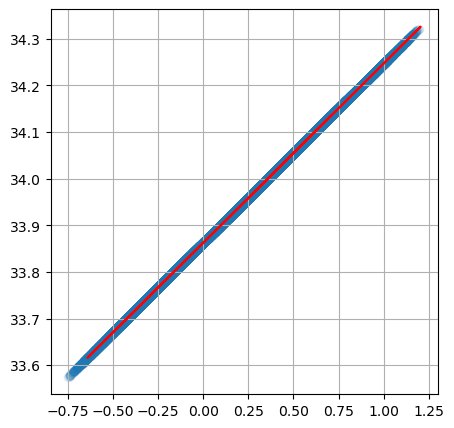

In [33]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(X[:,1],linpred,c='r')
plt.scatter(KO_temp_interp_ds.conservative_temperature,KO_salinity_pred,alpha=0.1)
plt.grid()

#### SVERDRUP

In [34]:
# load interpolated temp and salinity datasets
sverdrup_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_temp_profile.nc')
sverdrup_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_salt_profile.nc')

In [35]:
linpred, params_sver, sver_salinity_pred = pred_salt_from_temp_linear_fit(sverdrup_ds,sverdrup_temp_interp_ds)

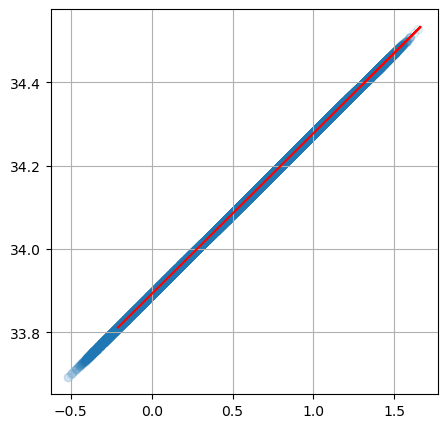

In [36]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(sverdrup_ds.sel(depth_temperatureerature=sverdrup_ds.depth_CTD.values).temperature.sel(time=slice('2019-03','2019-06')).values.ravel(),linpred,c='r')
plt.scatter(sverdrup_temp_interp_ds.conservative_temperature,sver_salinity_pred,alpha=0.1)
plt.grid()

## Now add lines to TS multi-panel plot

In [37]:
temp_array = np.arange(-1.5,3,0.5)

In [38]:
def create_linear_fit(params, temp_array):
    salt_pred = params[0] + params[1]*temp_array
    return salt_pred

Calculate linear fit for each site to plot with obs

In [39]:
rinkfish_linfit_salt = create_linear_fit(params_rinkfish, temp_array)
kong_linfit_salt = create_linear_fit(params_kong, temp_array)
sver_linfit_salt = create_linear_fit(params_sver, temp_array)

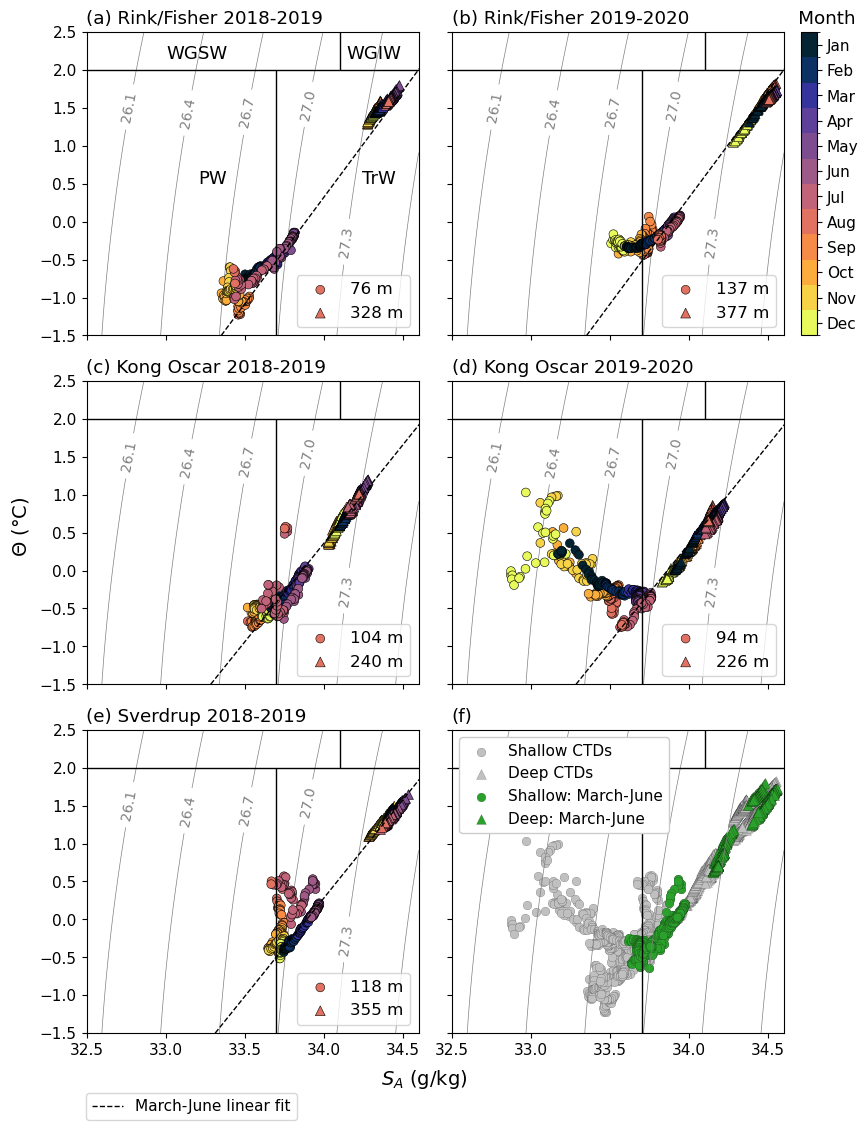

In [40]:
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[9,13])
(ax1,ax2,ax3,ax4,ax5,ax6) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

# plot all mooring data in gray for bottom right plot ================================================
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.depth_CTD.values.max()

    ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_shallow),\
                mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow),\
                c='silver', s=40, edgecolor='k',linewidth=0.1)
    ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_deep),\
                mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep),\
                c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1);
    
## Plot March-June points ================================================
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.depth_CTD.values.max()
    
    if '2018' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow,\
                                                          depth_temperatureerature=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep,\
                                                          depth_temperatureerature=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1)
    if '2019' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_shallow,\
                                                          depth_temperatureerature=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_deep,\
                                                          depth_temperatureerature=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1);   
# plot density contour
cs = ax6.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(26.1,27.7,.3),linewidths=0.5,zorder=1)

# for legend  
ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow).isel(time=0),\
            c='silver', s=40, edgecolor='k',linewidth=0.1, label='Shallow CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep).isel(time=0),\
            c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1, label='Deep CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow,\
                                                  depth_temperatureerature=ctd_depth_shallow).isel(time=0),\
            c='tab:green', s=40, edgecolor='k',linewidth=0.1, label='Shallow: March-June')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep,\
                                                  depth_temperatureerature=ctd_depth_deep).isel(time=0),\
            c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1, label='Deep: March-June')

legend = ax6.legend(loc='upper left',fontsize=11,facecolor='white', framealpha=1)

## Mooring specific TS plots ================================================
# loop through each axis and mooring dataset to plot each TS plot
for ax,mooring_ds_i in zip([ax1,ax2,ax3,ax4,ax5],mooring_data_list):
    # assign mooring dataset
    mooring_ds = mooring_ds_i
    
    # PLOT -------------------------------------------------------
    # plot density contour
    cs = ax.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(26.1,27.7,.3),linewidths=0.5,zorder=1)
#     if ax!=ax1:
#         # manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(33.6,1.5),(34,1.5),(34.4,1.5)] # old positions
#         manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(34,1.5),(34.1,-0.25)]
#         cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
        
    # manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(33.6,1.5),(34,1.5),(34.4,1.5)] # old positions
    manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(34,1.5),(34.1,-0.25)]
    cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
    
    # plot all mooring data in gray ------------------------------------
#     for mooring_ds_i in mooring_data_list:
#         ctd_depth_shallow = mooring_ds_i.depth_CTD.values.min()
#         ctd_depth_deep = mooring_ds_i.depth_CTD.values.max()
    
#         ax.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_shallow),\
#                     mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_shallow),\
#                     c='silver', s=40, edgecolor='k',linewidth=0.1)
#         ax.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_deep),\
#                    mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_deep),\
#                    c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1)
    
    # mooring data in color --------------------------------------------
    cmap = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    # cmap = mpl.cm.viridis
    bounds = np.arange(0.5,13.5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.depth_CTD.values.max()
    # extract times
    dates = mooring_ds.salinity.dropna(dim='time').time
    da_months  = dates.dt.strftime("%m")
    ax.scatter(mooring_ds.salinity.sel(depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow).dropna(dim='time'),\
                c=da_months, s=40, edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_shallow)+' m')
    ax.scatter(mooring_ds.salinity.sel(depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep).dropna(dim='time'),\
                c=da_months,s=50, marker='^',edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_deep)+' m')
    if ax==ax2:
        axins = inset_axes(
            ax2,
            width="5%",  # width: 5% of parent_bbox width
            height="100%",
            loc="upper left",
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=ax2.transAxes,
            borderpad=0)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=np.arange(1,13))
        cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        cb.ax.set_title("      Month")
        cb.ax.invert_yaxis()
    
    # ax.set_ylabel('$\mathit{\Theta}$ (°C)')
    # ax.set_xlabel("Salinity")
    ax.legend(loc='lower right',fontsize=12)

## add titles
ax1.set_title("(a) Rink/Fisher 2018-2019", loc='left')
ax2.set_title("(b) Rink/Fisher 2019-2020", loc='left')
ax3.set_title("(c) Kong Oscar 2018-2019", loc='left')
ax4.set_title("(d) Kong Oscar 2019-2020", loc='left')
ax5.set_title("(e) Sverdrup 2018-2019", loc='left')
ax6.set_title("(f)", loc='left')

## plot lines to delineate water masses
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.axhline(y=2, c="k", linewidth=1)
    ax.vlines(x=33.7, ymin=-2, ymax=2, colors="k", linewidth=1)
    ax.vlines(x=34.1, ymin=2, ymax=2.5, colors="k", linewidth=1)
    ax.set_ylim(-1.5,2.5)
    ax.set_xlim(32.5,34.6)
    
    if ax==ax1:
        ax.text(33.2,2.15,"WGSW",size=13, ha='center')
        ax.text(34.32,2.15,"WGIW",size=13, ha='center')
        ax.text(33.3,0.5,"PW",size=13, ha='center')
        ax.text(34.35,0.5,"TrW",size=13, ha='center')

fig.text(0.5, 0.07, '$S_A$ (g/kg)', size=14, ha='center')
fig.text(0.04, 0.5, '$\mathit{\Theta}$ (°C)', size=14, va='center', rotation='vertical');

## add linear fit to each subplot
ax1.plot(rinkfish_linfit_salt, temp_array, 'k', linewidth=1, linestyle = 'dashed');
ax2.plot(rinkfish_linfit_salt, temp_array, 'k', linewidth=1, linestyle = 'dashed');
ax3.plot(kong_linfit_salt, temp_array, 'k', linewidth=1, linestyle = 'dashed');
ax4.plot(kong_linfit_salt, temp_array, 'k', linewidth=1, linestyle = 'dashed');
ax5.plot(sver_linfit_salt, temp_array, 'k', linewidth=1, linestyle = 'dashed');

## add custom legend for dashed line
line = Line2D([0], [0], color='k', linewidth=1, linestyle='--')
fig.legend([line], ['March-June linear fit'], bbox_to_anchor=[0.367,0.07]);

# plt.savefig("figures/TS_plots_all_with_linearfit.png", bbox_inches='tight', dpi=300, facecolor='white');

## next version with ship CTD profiles

In [53]:
ship_ctds_2018_ds = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_binned/combined/OMG_Narwhals_Ocean_CTD_Greenland_2018.nc')
ship_ctds_2019_ds = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_binned/combined/OMG_Narwhals_Ocean_CTD_Greenland_2019.nc')
ship_ctds_2020_ds = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_binned/combined/OMG_Narwhals_Ocean_CTD_Greenland_2020.nc')

In [54]:
# make depth correction for 2018 and 2019
ship_ctds_2018_ds['depth'] = ship_ctds_2018_ds.depth + 33
ship_ctds_2019_ds['depth'] = ship_ctds_2019_ds.depth + 33

ship_ctds_2018_ds['pressure'] = ship_ctds_2018_ds.pressure + 33
ship_ctds_2019_ds['pressure'] = ship_ctds_2019_ds.pressure + 33

In [55]:
# for some reason this doesn't work within a function
# 2018 -----
tmp = ship_ctds_2018_ds.swap_dims({'profile':'time'})
# absolute salinity
SA = gsw.conversions.SA_from_SP(tmp.salinity,tmp.pressure,tmp.lon,tmp.lat)
# conservative temp
CT = gsw.conversions.CT_from_t(SA,tmp.temperature,tmp.pressure)
# replace values in 
ship_ctds_2018_ds['potential_temperature'] = CT
ship_ctds_2018_ds['salinity'] = SA

# 2019 -----
tmp = ship_ctds_2019_ds.swap_dims({'profile':'time'})
# absolute salinity
SA = gsw.conversions.SA_from_SP(tmp.salinity,tmp.pressure,tmp.lon,tmp.lat)
# conservative temp
CT = gsw.conversions.CT_from_t(SA,tmp.temperature,tmp.pressure)
# replace values in 
ship_ctds_2019_ds['potential_temperature'] = CT
ship_ctds_2019_ds['salinity'] = SA

# 2020 -----
tmp = ship_ctds_2020_ds.swap_dims({'profile':'time'})
# absolute salinity
SA = gsw.conversions.SA_from_SP(tmp.salinity,tmp.pressure,tmp.lon,tmp.lat)
# conservative temp
CT = gsw.conversions.CT_from_t(SA,tmp.temperature,tmp.pressure)
# replace values in 
ship_ctds_2020_ds['potential_temperature'] = CT
ship_ctds_2020_ds['salinity'] = SA

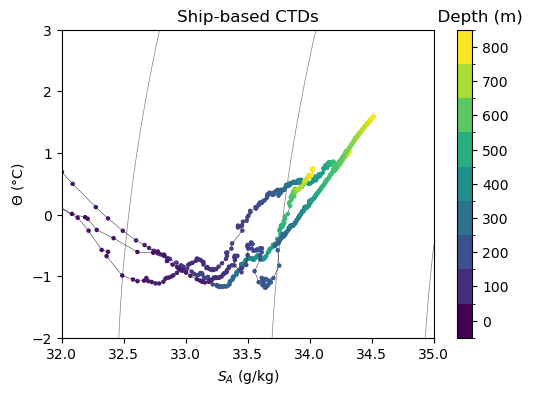

In [43]:
# plot all CTD profiles on T-S plot

# calculate density contours
theta_vals = np.linspace(-2, 8.5, 156)
salt_vals  = np.linspace(22, 35, 156)
Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)

fig, ax1 = plt.subplots(1,1,figsize=[6,4])

# plot density contour ----------------------------------------------
cs = ax1.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(18,29,1),linewidths=0.5,zorder=1)
manual_locations = [(22,7.5),(24,7.5),(26,7.5),(27,7.5),(28,7.5),(30,7.5),(31,7.5),(32,7.5),(34,7.5),(36,7.5)]
cl = ax1.clabel(cs, fontsize=10, inline=True, fmt='%.0f',manual=manual_locations)

# plot ctd profiles with color for depth ----------------------------
# cmap = cmocean.cm.thermal
# colors = cmocean.cm.phase
cmap = mpl.cm.viridis
bounds = np.arange(-50,950,100)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# for ctds_ds in [ship_ctds_2020_ds, ship_ctds_2019_ds, ship_ctds_2018_ds]:
for ctds_ds in [ship_ctds_2020_ds]:
    ctds_ds = ctds_ds.where(ctds_ds.depth>0, drop=True)
    for i in range(len(ctds_ds.time)):
        ax1.plot(ctds_ds.salinity.isel(time=i), ctds_ds.potential_temperature.isel(time=i),\
                 c='k',linewidth=0.3, zorder=1)
        ax1.scatter(ctds_ds.salinity.isel(time=i), ctds_ds.potential_temperature.isel(time=i),s=5,\
                    c=ctds_ds.depth, cmap=cmap)
    
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1, ticks=np.arange(0,900,100))
cb.ax.set_title("      Depth (m)")

ax1.set_ylabel('$\mathit{\Theta}$ (°C)')
ax1.set_xlabel('$S_A$ (g/kg)')

ax1.set_title('Ship-based CTDs');

ax1.set_xlim(24,35)
ax1.set_ylim(-2,8.5);
# zoom in
plt.xlim(32,35)
plt.ylim(-2,3);

# plt.savefig("figures/TS_relationship/" + filename + ".png", bbox_inches='tight', dpi=300, facecolor='white');
    
plt.show();

In [44]:
ship_ctds_2019_ds.time.values

array(['2019-08-03T15:03:28.000000000', '2019-08-03T16:08:26.000000000',
       '2019-08-03T17:31:28.000000000', '2019-08-03T18:40:32.000000000',
       '2019-08-03T20:58:18.000000000', '2019-08-04T15:15:09.000000000',
       '2019-08-04T16:55:26.000000000', '2019-08-04T18:22:33.000000000',
       '2019-08-04T20:51:33.000000000', '2019-08-05T12:02:56.000000000',
       '2019-08-05T14:17:25.000000000', '2019-08-05T16:46:39.000000000',
       '2019-08-05T19:47:46.000000000', '2019-08-06T13:19:08.000000000',
       '2019-08-06T20:16:01.000000000', '2019-08-07T10:35:44.000000000',
       '2019-08-07T13:41:26.000000000'], dtype='datetime64[ns]')

In [57]:
ctds_2018 = ship_ctds_2018_ds.where(ship_ctds_2018_ds.depth>0, drop=True).sel(time=['2018-08-23T00:55:11','2018-08-25T18:00:08','2018-08-24T11:33:38','2018-08-25T19:46:31'])
# ctds_2019 = ship_ctds_2019_ds.where(ship_ctds_2019_ds.depth>0, drop=True).sel(time=['2019-08-03T15:03:28','2019-08-04T15:15:09','2019-08-05T12:02:56','2019-08-05T19:47:46'])
ctds_2019 = ship_ctds_2019_ds.where(ship_ctds_2019_ds.depth>0, drop=True).sel(time=['2019-08-03T15:03:28','2019-08-04T16:55:26','2019-08-05T12:02:56'])
ctds_2020 = ship_ctds_2020_ds.where(ship_ctds_2020_ds.depth>0, drop=True).sel(time=['2020-08-09T21:11:17','2020-08-11T00:12:28'])

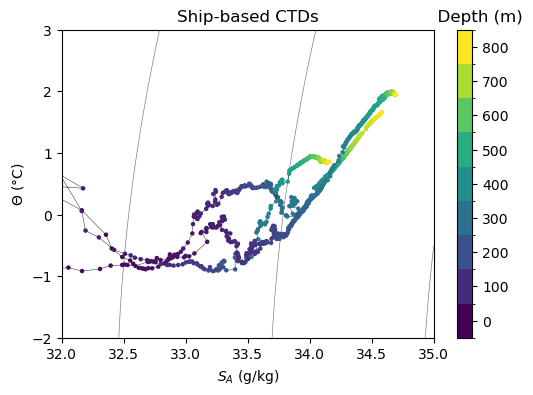

In [46]:
# plot all CTD profiles on T-S plot

# calculate density contours
theta_vals = np.linspace(-2, 8.5, 156)
salt_vals  = np.linspace(22, 35, 156)
Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)

fig, ax1 = plt.subplots(1,1,figsize=[6,4])

# plot density contour ----------------------------------------------
cs = ax1.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(18,29,1),linewidths=0.5,zorder=1)
manual_locations = [(22,7.5),(24,7.5),(26,7.5),(27,7.5),(28,7.5),(30,7.5),(31,7.5),(32,7.5),(34,7.5),(36,7.5)]
cl = ax1.clabel(cs, fontsize=10, inline=True, fmt='%.0f',manual=manual_locations)

# plot ctd profiles with color for depth ----------------------------
# cmap = cmocean.cm.thermal
# colors = cmocean.cm.phase
cmap = mpl.cm.viridis
bounds = np.arange(-50,950,100)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for ctds_ds in [ctds_2019]:
# for ctds_ds in [ctds_2018, ctds_2019, ctds_2020]:
    ctds_ds = ctds_ds.where(ctds_ds.depth>0, drop=True)
    for i in range(len(ctds_ds.time)):
        ax1.plot(ctds_ds.salinity.isel(time=i), ctds_ds.potential_temperature.isel(time=i),\
                 c='k',linewidth=0.3, zorder=1)
        ax1.scatter(ctds_ds.salinity.isel(time=i), ctds_ds.potential_temperature.isel(time=i),s=5,\
                    c=ctds_ds.depth, cmap=cmap)
    
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1, ticks=np.arange(0,900,100))
cb.ax.set_title("      Depth (m)")

ax1.set_ylabel('$\mathit{\Theta}$ (°C)')
ax1.set_xlabel('$S_A$ (g/kg)')

ax1.set_title('Ship-based CTDs');

ax1.set_xlim(24,35)
ax1.set_ylim(-2,8.5);
# zoom in
plt.xlim(32,35)
plt.ylim(-2,3);

# plt.savefig("figures/TS_relationship/" + filename + ".png", bbox_inches='tight', dpi=300, facecolor='white');
    
plt.show();

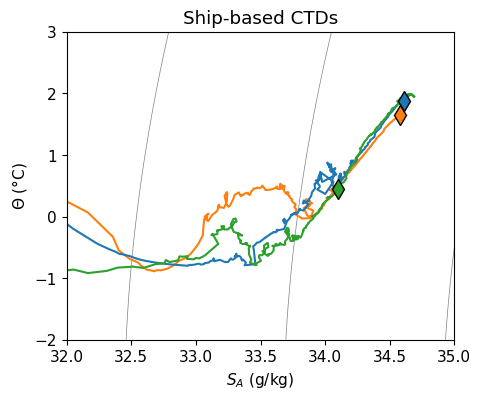

In [124]:
# plot all CTD profiles on T-S plot

# calculate density contours
theta_vals = np.linspace(-2, 8.5, 156)
salt_vals  = np.linspace(22, 35, 156)
Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)

fig, ax1 = plt.subplots(1,1,figsize=[5,4])

# plot density contour ----------------------------------------------
cs = ax1.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(18,29,1),linewidths=0.5,zorder=1)
manual_locations = [(22,7.5),(24,7.5),(26,7.5),(27,7.5),(28,7.5),(30,7.5),(31,7.5),(32,7.5),(34,7.5),(36,7.5)]
cl = ax1.clabel(cs, fontsize=10, inline=True, fmt='%.0f',manual=manual_locations)

# plot ctd profiles with color for depth ----------------------------
# cmap = cmocean.cm.thermal
# colors = cmocean.cm.phase
cmap = mpl.cm.viridis
bounds = np.arange(-50,950,100)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ctds_2019 = ship_ctds_2019_ds.where(ship_ctds_2019_ds.depth>0, drop=True).sel(time=['2019-08-03T15:03:28','2019-08-04T16:55:26','2019-08-05T12:02:56'])
ax1.plot(ctds_2019.salinity.isel(time=0), ctds_2019.potential_temperature.isel(time=0),c='tab:orange',linewidth=1.5, zorder=1) # sverdrup
ax1.plot(ctds_2019.salinity.isel(time=1), ctds_2019.potential_temperature.isel(time=1),c='tab:blue',linewidth=1.5, zorder=1) # kong oscar
ax1.plot(ctds_2019.salinity.isel(time=2), ctds_2019.potential_temperature.isel(time=2),c='tab:green',linewidth=1.5, zorder=1) # rink

ax1.plot(ctds_2019.salinity.isel(time=0).sel(depth=400), ctds_2019.potential_temperature.isel(time=0).sel(depth=400),marker='d',\
         markersize=10,markerfacecolor='tab:orange',c='k',zorder=1) # sverdrup - 400m was deepest
ax1.plot(ctds_2019.salinity.isel(time=1).sel(depth=588), ctds_2019.potential_temperature.isel(time=1).sel(depth=588),marker='d',\
         markersize=10,markerfacecolor='tab:blue',c='k',zorder=1) # kong oscar - 588 was deepest
ax1.plot(ctds_2019.salinity.isel(time=2).sel(depth=243), ctds_2019.potential_temperature.isel(time=2).sel(depth=243),marker='d',\
         markersize=10,markerfacecolor='tab:green',c='k',zorder=1) # rink

ax1.set_ylabel('$\mathit{\Theta}$ (°C)')
ax1.set_xlabel('$S_A$ (g/kg)')

ax1.set_title('Ship-based CTDs');

ax1.set_xlim(24,35)
ax1.set_ylim(-2,8.5);
# zoom in
plt.xlim(32,35)
plt.ylim(-2,3);

# plt.savefig("figures/TS_relationship/" + filename + ".png", bbox_inches='tight', dpi=300, facecolor='white');
    
plt.show();

In [145]:
ctds_2019.potential_temperature.isel(time=0).sel(depth=400).values

array(1.65597672)

In [175]:
# calculate freezing point of ice (Following straneo et al. 2011: https://static-content.springer.com/esm/art%3A10.1038%2Fngeo1109/MediaObjects/41561_2011_BFngeo1109_MOESM583_ESM.pdf)
-1.5-334500/3980-2100/3980*(-1.5+10)

-90.03015075376884

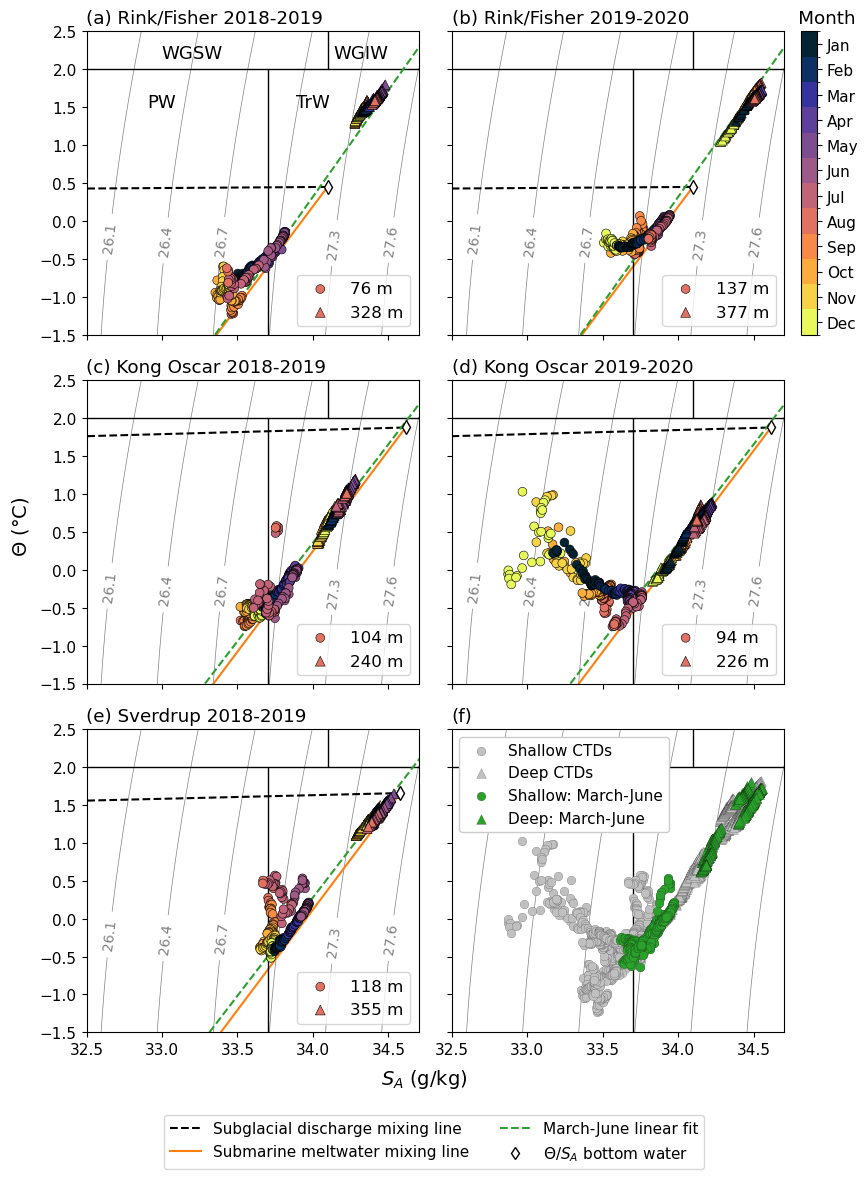

In [80]:
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[9,13])
(ax1,ax2,ax3,ax4,ax5,ax6) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

# plot all mooring data in gray for bottom right plot ================================================
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.depth_CTD.values.max()

    ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_shallow),\
                mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow),\
                c='silver', s=40, edgecolor='k',linewidth=0.1,zorder=3)
    ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_deep),\
                mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep),\
                c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1,zorder=3);
    
## Plot March-June points ================================================
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.depth_CTD.values.max()
    
    if '2018' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow,\
                                                          depth_temperatureerature=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1,zorder=4)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep,\
                                                          depth_temperatureerature=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1,zorder=4)
    if '2019' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_shallow,\
                                                          depth_temperatureerature=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1,zorder=4)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), depth_CTD=ctd_depth_deep,\
                                                          depth_temperatureerature=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1,zorder=4);   
# plot density contour
cs = ax6.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(26.1,27.7,.3),linewidths=0.5,zorder=1)

# for legend  
ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow).isel(time=0),\
            c='silver', s=40, edgecolor='k',linewidth=0.1, label='Shallow CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep).isel(time=0),\
            c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1, label='Deep CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_shallow,\
                                                  depth_temperatureerature=ctd_depth_shallow).isel(time=0),\
            c='tab:green', s=40, edgecolor='k',linewidth=0.1, label='Shallow: March-June')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), depth_CTD=ctd_depth_deep,\
                                                  depth_temperatureerature=ctd_depth_deep).isel(time=0),\
            c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1, label='Deep: March-June')

legend = ax6.legend(loc='upper left',fontsize=11,facecolor='white', framealpha=1)

## Mooring specific TS plots ================================================
# loop through each axis and mooring dataset to plot each TS plot
for ax,mooring_ds_i in zip([ax1,ax2,ax3,ax4,ax5],mooring_data_list):
    # assign mooring dataset
    mooring_ds = mooring_ds_i
    
    # PLOT -------------------------------------------------------
    # plot density contour
    cs = ax.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(26.1,27.7,.3),linewidths=0.5,zorder=1)
#     if ax!=ax1:
#         # manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(33.6,1.5),(34,1.5),(34.4,1.5)] # old positions
#         manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(34,1.5),(34.1,-0.25)]
#         cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
        
    # manual_locations = [(32.8,1.5),(33,1.5),(33.4,1.5),(34,1.5),(34.1,-0.25)] # old positions
    manual_locations = [(32.8,-0.25),(33,-0.25),(33.4,-0.25),(34,-0.25),(34.5,-0.25)] # old positions
    cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
    
    # mooring data in color --------------------------------------------
    cmap = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    # cmap = mpl.cm.viridis
    bounds = np.arange(0.5,13.5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.depth_CTD.values.max()
    # extract times
    dates = mooring_ds.salinity.dropna(dim='time').time
    da_months  = dates.dt.strftime("%m")
    ax.scatter(mooring_ds.salinity.sel(depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(depth_CTD=ctd_depth_shallow,depth_temperatureerature=ctd_depth_shallow).dropna(dim='time'),\
                c=da_months, s=40, edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_shallow)+' m',zorder=4)
    ax.scatter(mooring_ds.salinity.sel(depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(depth_CTD=ctd_depth_deep,depth_temperatureerature=ctd_depth_deep).dropna(dim='time'),\
                c=da_months,s=50, marker='^',edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_deep)+' m',zorder=4)
    if ax==ax2:
        axins = inset_axes(
            ax2,
            width="5%",  # width: 5% of parent_bbox width
            height="100%",
            loc="upper left",
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=ax2.transAxes,
            borderpad=0)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=np.arange(1,13))
        cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        cb.ax.set_title("      Month")
        cb.ax.invert_yaxis()
    
    # ax.set_ylabel('$\mathit{\Theta}$ (°C)')
    # ax.set_xlabel("Salinity")
    ax.legend(loc='lower right',fontsize=12)

## add titles
ax1.set_title("(a) Rink/Fisher 2018-2019", loc='left')
ax2.set_title("(b) Rink/Fisher 2019-2020", loc='left')
ax3.set_title("(c) Kong Oscar 2018-2019", loc='left')
ax4.set_title("(d) Kong Oscar 2019-2020", loc='left')
ax5.set_title("(e) Sverdrup 2018-2019", loc='left')
ax6.set_title("(f)", loc='left')

## plot lines to delineate water masses
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.axhline(y=2, c="k", linewidth=1)
    ax.vlines(x=33.7, ymin=-2, ymax=2, colors="k", linewidth=1)
    ax.vlines(x=34.1, ymin=2, ymax=2.5, colors="k", linewidth=1)
    ax.set_ylim(-1.5,2.5)
    ax.set_xlim(32.5,34.7)
    
    if ax==ax1:
        ax.text(33.2,2.15,"WGSW",size=13, ha='center')
        ax.text(34.32,2.15,"WGIW",size=13, ha='center')
        ax.text(33,1.5,"PW",size=13, ha='center')
        ax.text(34,1.5,"TrW",size=13, ha='center')

fig.text(0.5, 0.07, '$S_A$ (g/kg)', size=14, ha='center')
fig.text(0.04, 0.5, '$\mathit{\Theta}$ (°C)', size=14, va='center', rotation='vertical');

## add linear fit to each subplot
ax1.plot(rinkfish_linfit_salt, temp_array, 'tab:green', linewidth=1.5, linestyle = 'dashed');
ax2.plot(rinkfish_linfit_salt, temp_array, 'tab:green', linewidth=1.5, linestyle = 'dashed');
ax3.plot(kong_linfit_salt, temp_array, 'tab:green', linewidth=1.5, linestyle = 'dashed');
ax4.plot(kong_linfit_salt, temp_array, 'tab:green', linewidth=1.5, linestyle = 'dashed');
ax5.plot(sver_linfit_salt, temp_array, 'tab:green', linewidth=1.5, linestyle = 'dashed');

## add subglacial discharge and submarine melt mixing lines
ctds_2019 = ship_ctds_2019_ds.where(ship_ctds_2019_ds.depth>0, drop=True).sel(time=['2019-08-03T15:03:28','2019-08-04T16:55:26','2019-08-05T12:02:56'])
# rink/fisher
ax1.plot([0,ctds_2019.salinity.isel(time=2).sel(depth=243).values],[0, ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values],'k',linewidth=1.5,linestyle='dashed',zorder=1)
ax2.plot([0,ctds_2019.salinity.isel(time=2).sel(depth=243).values],[0, ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values],'k',linewidth=1.5,linestyle='dashed',zorder=1)
ax1.plot([0,ctds_2019.salinity.isel(time=2).sel(depth=243).values],[-90, ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values],'tab:orange',linewidth=1.5,linestyle='solid',zorder=1)
ax2.plot([0,ctds_2019.salinity.isel(time=2).sel(depth=243).values],[-90, ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values],'tab:orange',linewidth=1.5,linestyle='solid',zorder=1)
# kong oscar
ax3.plot([0,ctds_2019.salinity.isel(time=1).sel(depth=588).values],[0, ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values],'k',linewidth=1.5,linestyle='dashed',zorder=1)
ax4.plot([0,ctds_2019.salinity.isel(time=1).sel(depth=588).values],[0, ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values],'k',linewidth=1.5,linestyle='dashed',zorder=1)
ax3.plot([0,ctds_2019.salinity.isel(time=1).sel(depth=588).values],[-90, ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values],'tab:orange',linewidth=1.5,linestyle='solid',zorder=1)
ax4.plot([0,ctds_2019.salinity.isel(time=1).sel(depth=588).values],[-90, ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values],'tab:orange',linewidth=1.5,linestyle='solid',zorder=1)
# sverdrup
ax5.plot([0,ctds_2019.salinity.isel(time=0).sel(depth=400).values],[0, ctds_2019.potential_temperature.isel(time=0).sel(depth=400).values],'k',linewidth=1.5,linestyle='dashed',zorder=1)
ax5.plot([0,ctds_2019.salinity.isel(time=0).sel(depth=400).values],[-90, ctds_2019.potential_temperature.isel(time=0).sel(depth=400).values],'tab:orange',linewidth=1.5,linestyle='solid',zorder=1)

## add points for bottom water diamond
ax1.plot(ctds_2019.salinity.isel(time=2).sel(depth=243).values,ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values,markeredgecolor='k',markerfacecolor='w',marker='d',markersize=7,zorder=4)
ax2.plot(ctds_2019.salinity.isel(time=2).sel(depth=243).values,ctds_2019.potential_temperature.isel(time=2).sel(depth=243).values,markeredgecolor='k',markerfacecolor='w',marker='d',markersize=7,zorder=4)
ax3.plot(ctds_2019.salinity.isel(time=1).sel(depth=588).values,ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values,markeredgecolor='k',markerfacecolor='w',marker='d',markersize=7,zorder=4)
ax4.plot(ctds_2019.salinity.isel(time=1).sel(depth=588).values,ctds_2019.potential_temperature.isel(time=1).sel(depth=588).values,markeredgecolor='k',markerfacecolor='w',marker='d',markersize=7,zorder=4)
ax5.plot(ctds_2019.salinity.isel(time=0).sel(depth=400).values,ctds_2019.potential_temperature.isel(time=0).sel(depth=400).values,markeredgecolor='k',markerfacecolor='w',marker='d',markersize=7,zorder=4)

## add custom legend for dashed line
line1 = Line2D([0], [0], color='k', linewidth=1.5, linestyle='--')
line2 = Line2D([0], [0], color='tab:orange', linewidth=1.5, linestyle='-')
line3 = Line2D([0], [0], color='tab:green', linewidth=1.5, linestyle='--')
point = Line2D([0], [0], marker='d', markersize=6, markeredgecolor='k', markerfacecolor='w', linestyle='')
fig.legend([line1,line2,line3,point], ['Subglacial discharge mixing line','Submarine meltwater mixing line','March-June linear fit','$\mathit{\Theta}/S_{A}$ bottom water'],\
           ncol=2, bbox_to_anchor=[0.82,0.052]);

plt.savefig("figures/TS_plots_all_with_mixinglines.png", bbox_inches='tight', dpi=300, facecolor='white');

## Make multi-panel plot showing difference in expected salinity (using linear fit) and observed salinity

In [32]:
from matplotlib import gridspec

**Without runoff**

In [87]:
KO_salt_interp_ds.absolute_salinity-KO_salinity_pred

<xarray.DataArray (time: 715, depth: 100)> Size: 572kB
array([[        nan,         nan, -0.07167213, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.067194  , ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.0840372 , ...,         nan,
                nan,         nan],
       ...,
       [ 0.0004317 , -0.00126431, -0.00295984, ...,         nan,
                nan,         nan],
       [-0.00318877, -0.00555017, -0.00791106, ...,         nan,
                nan,         nan],
       [-0.01073274, -0.01429158, -0.01784984, ...,         nan,
                nan,         nan]])
Coordinates:
  * time                       (time) datetime64[ns] 6kB 2018-08-28 ... 2020-...
  * depth                      (depth) float64 800B 94.0 95.65 ... 255.8 257.5
    serial_number_CTD          (depth) <U14 6kB 'SBE37_03716754' ... 'SBE37_0...
    serial_number_temperature  (depth) <U14 6kB ...

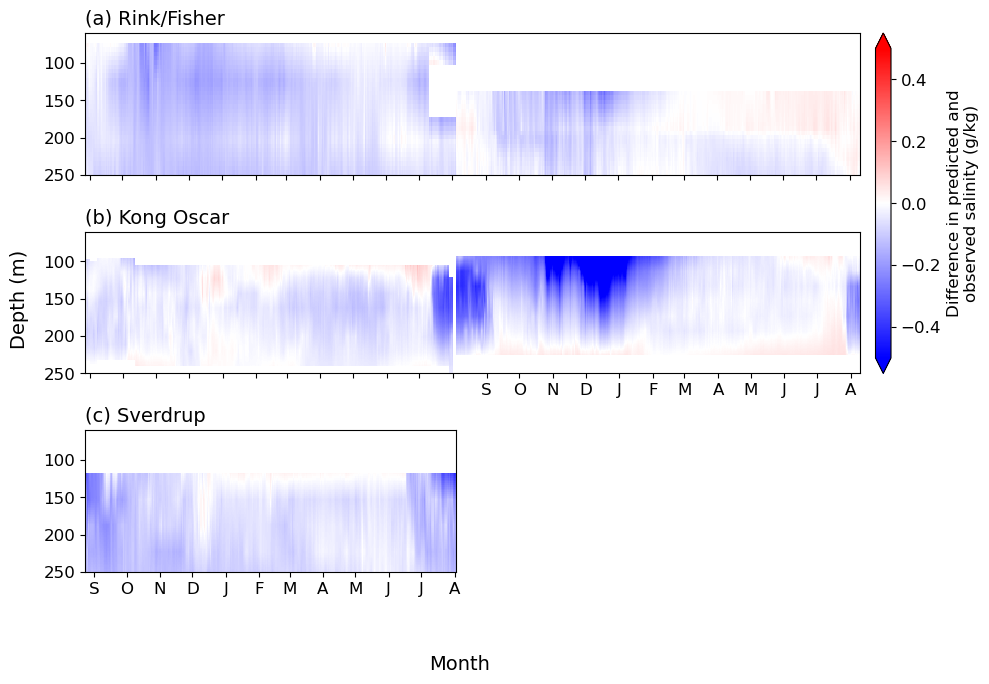

In [91]:
#### create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017)

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(3,2,(1,2)) # three rows, two colums, combined first and second cell
ax2 = fig.add_subplot(3,2,(3,4)) # three rows, two colums, combined third and fourth cell
ax3 = fig.add_subplot(spec[4])

plt.subplots_adjust(hspace=0.4)
plt.rcParams['font.size'] = '12'

(rinkfisher_salt_interp_ds.absolute_salinity-rinkfisher_salinity_pred).plot(ax=ax1,cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)
cbar = (KO_salt_interp_ds.absolute_salinity-KO_salinity_pred).plot(y='depth',ax=ax2,cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False, extend='both')
(sverdrup_salt_interp_ds.absolute_salinity-sver_salinity_pred).plot(ax=ax3,cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)

ax1.set_title("")
ax2.set_title("")
ax3.set_title("")

# subplot labels -----------------------------------------------------------------------
ax1.set_title("(a) Rink/Fisher",loc='left',fontsize = 14)
ax2.set_title("(b) Kong Oscar",loc='left',fontsize = 14)
ax3.set_title("(c) Sverdrup",loc='left',fontsize = 14)

# remove y-axis tick labels for subplot 2
# ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(250,60)
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months, [])
ax2.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax3.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

# add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax2,
    width="2%",  # width: 5% of parent_bbox width
    height="240%",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.4, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax2.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Difference in predicted and\nobserved salinity (g/kg)', orientation='vertical', extend='both')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.05, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

plt.savefig("figures/Salinity_pred-obs_linear-fig.png", bbox_inches='tight', dpi=300)

**With runoff**

Updated figure with runoff included

In [92]:
# load netCDFs for runoff data
runoff_dir = '/Users/mariezahn/Documents/Work/PhD/Chapter_3/OMG_Python_dir/glacier_discharge/'

rink_racmo_ds = xr.open_dataset(runoff_dir + 'netcdfs/racmo_freshwater_discharge_Rink_Gletsjer.nc')
rink_mar_ds =   xr.open_dataset(runoff_dir + 'netcdfs/mar_freshwater_discharge_Rink_Gletsjer.nc')

KO_racmo_ds = xr.open_dataset(runoff_dir + 'netcdfs/racmo_freshwater_discharge_Nuussuup_Sermia.nc')
KO_mar_ds =   xr.open_dataset(runoff_dir + 'netcdfs/mar_freshwater_discharge_Nuussuup_Sermia.nc')

sver_racmo_ds = xr.open_dataset(runoff_dir + 'netcdfs/racmo_freshwater_discharge_Sverdrup_Gletsjer.nc')
sver_mar_ds =   xr.open_dataset(runoff_dir + 'netcdfs/mar_freshwater_discharge_Sverdrup_Gletsjer.nc')

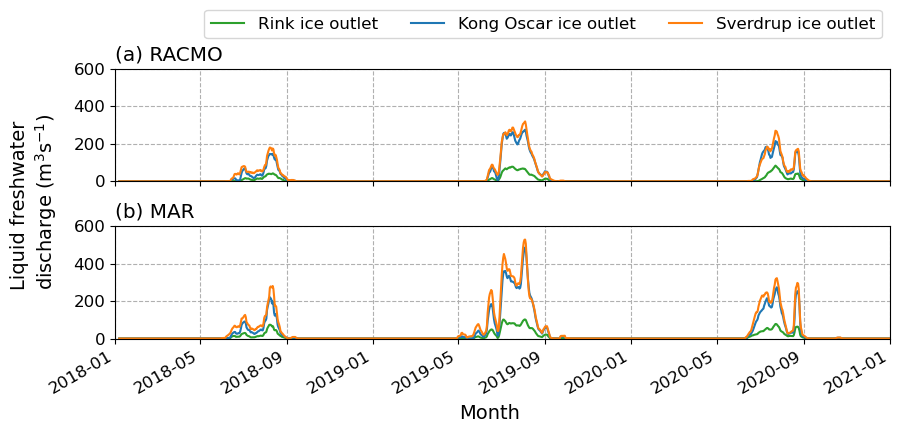

In [34]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, sharey=True)
plt.rcParams["figure.figsize"] = (10,3.5)
plt.rcParams['font.size'] = 12
plt.subplots_adjust(hspace=0.4)

## RACMO
rink_glacier_racmo_7d = rink_racmo_ds.sel(station=30604).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_racmo_7d.plot(ax=ax1,c='tab:green',label='Rink ice outlet')

KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot(ax=ax1,c='tab:blue',label='Kong Oscar ice outlet')

sver_glacier_racmo_7d = sver_racmo_ds.sel(station=31992).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_racmo_7d.plot(ax=ax1,c='tab:orange',label='Sverdrup ice outlet')

ax1.legend(ncol=3,prop={'size': 12},bbox_to_anchor=(1, 1.6))
ax1.set_ylim(0,600)
ax1.grid(linestyle='dashed')
ax1.set_title("")
ax1.set_title("(a) RACMO",loc='left')
ax1.set_xlabel("")
ax1.set_ylabel("");
ax1.set_xlim(np.datetime64("2018-01-01"),np.datetime64("2021-01-01"))

## MAR
rink_glacier_mar_7d = rink_mar_ds.sel(station=30604).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_mar_7d.plot(ax=ax2,c='tab:green',label='Rink ice outlet')

KO_glacier_mar_7d = KO_mar_ds.sel(station=31202).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_mar_7d.plot(ax=ax2,c='tab:blue',label='Kong Oscar ice outlet')

sver_glacier_mar_7d = sver_mar_ds.sel(station=31992).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_mar_7d.plot(ax=ax2,c='tab:orange',label='Sverdrup ice outlet')

# ax2.legend()
# ax2.set_ylim(0,500)
ax2.grid(linestyle='dashed')
ax2.set_title("")
ax2.set_title("(b) MAR",loc='left')
ax2.set_xlabel("");
ax2.set_ylabel("");

fig.text(0.5, -0.12, 'Month', size=14, ha='center')
fig.text(0.02, 0.5, "Liquid freshwater\ndischarge (m$^3$s$^{-1}$)", size=14, va='center', rotation='vertical');

# plt.savefig("Glaciers_runoff.png", bbox_inches="tight", dpi=300)

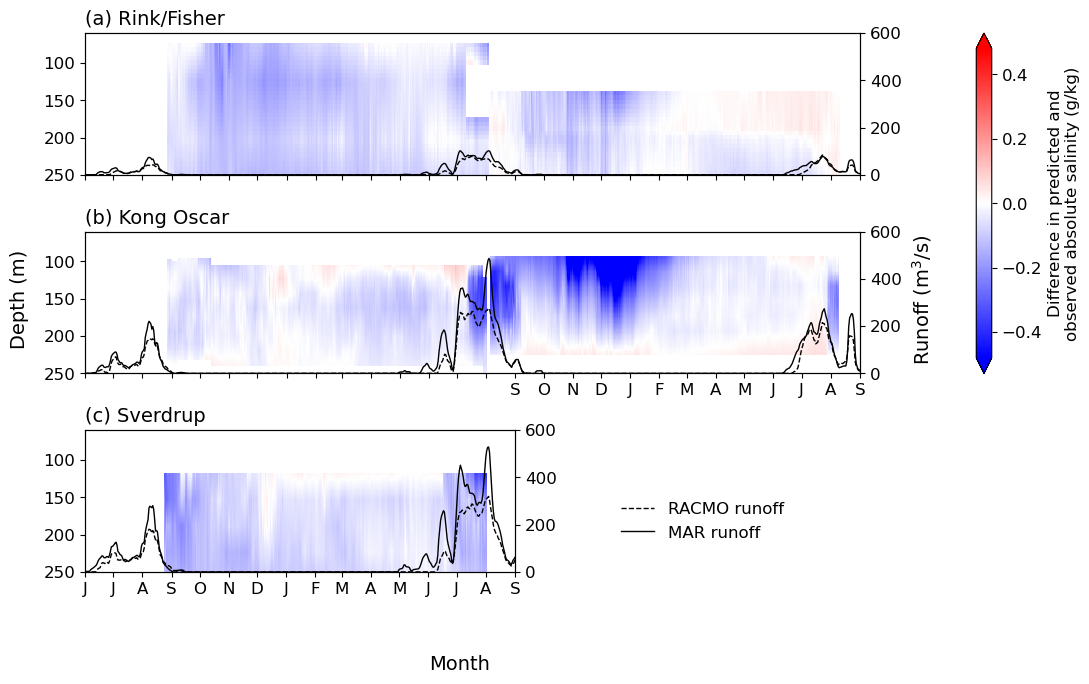

In [102]:
#### create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1.27, 1], wspace=0.017)

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(3,2,(1,2)) # three rows, two colums, combined first and second cell
ax2 = fig.add_subplot(3,2,(3,4)) # three rows, two colums, combined third and fourth cell
ax3 = fig.add_subplot(spec[4])

plt.subplots_adjust(hspace=0.4)
plt.rcParams['font.size'] = '12'

# plot salinity anomalies
(rinkfisher_salt_interp_ds.absolute_salinity-rinkfisher_salinity_pred).plot(ax=ax1,cmap='bwr',vmin=-.48, vmax=.48,add_colorbar=False)
cbar = (KO_salt_interp_ds.absolute_salinity-KO_salinity_pred).plot(y='depth',ax=ax2,cmap='bwr',vmin=-.48, vmax=.48,add_colorbar=False, extend='both')
(sverdrup_salt_interp_ds.absolute_salinity-sver_salinity_pred).plot(ax=ax3,cmap='bwr',vmin=-.48, vmax=.48,add_colorbar=False)

# plot runoff
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()

# RACMO
rink_glacier_racmo_7d = rink_racmo_ds.sel(station=30604).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_racmo_7d.plot.line('k--',ax=ax1_twin,linewidth=1) # rink ice outlet

KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot.line('k--',ax=ax2_twin,linewidth=1)

sver_glacier_racmo_7d = sver_racmo_ds.sel(station=31992).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_racmo_7d.plot.line('k--',ax=ax3_twin, label='RACMO runoff',linewidth=1)

# MAR
rink_glacier_mar_7d = rink_mar_ds.sel(station=30604).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_mar_7d.plot.line('k-',ax=ax1_twin,linewidth=1) # rink ice outlet

KO_glacier_mar_7d = KO_mar_ds.sel(station=31202).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_mar_7d.plot.line('k-',ax=ax2_twin,linewidth=1)

sver_glacier_mar_7d = sver_mar_ds.sel(station=31992).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_mar_7d.plot.line('k-',ax=ax3_twin,linewidth=1,label='MAR runoff')

# add legend for runoff
ax3_twin.legend(bbox_to_anchor=(1.66, 0.6),frameon=False)

# settings for ticks and tick labels ----------------------------------------------------
for ax in [ax1_twin, ax2_twin, ax3_twin]:
    ax.set_title("")
    ax.set_ylim(0,600)
    ax.set_ylabel("")
    
# remove the x and y ticks
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(250,60)

# subplot labels -----------------------------------------------------------------------
ax1.set_title("")
ax2.set_title("")
ax3.set_title("")

ax1.set_title("(a) Rink/Fisher",loc='left',fontsize = 14)
ax2.set_title("(b) Kong Oscar",loc='left',fontsize = 14)
ax3.set_title("(c) Sverdrup",loc='left',fontsize = 14)

# remove y-axis tick labels for subplot 2
# ax2.yaxis.set_ticklabels([])

months18 = pd.period_range(np.datetime64('2018-06'), freq='M', periods=16).strftime('%Y-%m').tolist()
# months19 = pd.period_range(np.datetime64('2019-06'), freq='M', periods=16).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-06'), freq='M', periods=28).strftime('%Y-%m').tolist()
abbrev = ["J","J","A","S","O",'N','D',"J",'F','M','A','M','J','J','A','S']
abbrev_long = ["","","","","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A','S']
ax1.set_xticks(months, [])
ax2.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax3.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax2,
    width="2%",  # width: 5% of parent_bbox width
    height="240%",
    loc="upper left",
    bbox_to_anchor=(1.15, 1.4, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax2.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Difference in predicted and\nobserved absolute salinity (g/kg)', orientation='vertical', extend='both')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.05, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');
fig.text(0.95, 0.5, "Runoff (m$^3$/s)", size=14, va='center', rotation='vertical');

plt.savefig("figures/Salinity_pred-obs_linear-fig.png", bbox_inches='tight', dpi=300)

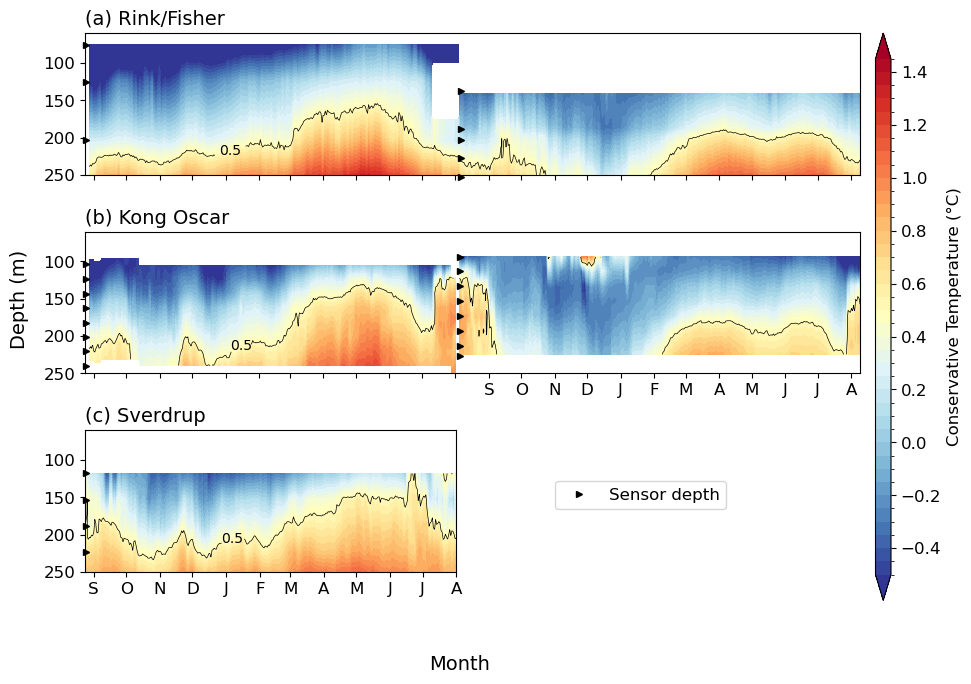

In [110]:
#### create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017)

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(3,2,(1,2)) # three rows, two colums, combined first and second cell
ax2 = fig.add_subplot(3,2,(3,4)) # three rows, two colums, combined third and fourth cell
ax3 = fig.add_subplot(spec[4])

plt.subplots_adjust(hspace=0.4)

plt.rcParams['font.size'] = '12'

# for all the same temp/salinity scales between all mooring plots:
levels_temp=np.arange(-0.5,1.5,0.05)

rinkfisher_temp_interp_ds.conservative_temperature.isel(station=0).plot.contourf(ax=ax1,cmap='RdYlBu_r',levels=levels_temp,add_colorbar=False)
cs1 = rinkfisher_temp_interp_ds.conservative_temperature.isel(station=0).plot.contour(ax=ax1,colors='k',levels=[0.5],linewidths=0.5,add_colorbar=False)
cbar = KO_temp_interp_ds.conservative_temperature.plot.contourf(y='depth',ax=ax2,cmap='RdYlBu_r',levels=levels_temp,add_colorbar=False, extend='both')
cs2 = KO_temp_interp_ds.conservative_temperature.plot.contour(y='depth',ax=ax2,colors='k',levels=[0.5],linewidths=0.5,add_colorbar=False)
sverdrup_temp_interp_ds.conservative_temperature.isel(station=0).plot.contourf(ax=ax3,cmap='RdYlBu_r',levels=levels_temp,add_colorbar=False)
cs3 = sverdrup_temp_interp_ds.conservative_temperature.isel(station=0).plot.contour(ax=ax3,colors='k',levels=[0.5],linewidths=0.5,add_colorbar=False)

# add isotherm label
cl = ax1.clabel(cs1, fontsize=10, fmt='%.1f',manual=[(17900,200)])
for l in cl:l.set_rotation(0)
cl = ax2.clabel(cs2, fontsize=10, fmt='%.1f',manual=[(17900,200)])
for l in cl:l.set_rotation(0)
cl = ax3.clabel(cs3, fontsize=10, fmt='%.1f',manual=[(17900,200)])
for l in cl:l.set_rotation(0)

# set axis limits
# ax1.set_ylim(rink_fisher_temp_interp_ds.depth.max(),rink_fisher_temp_interp_ds.depth.min()-50)
# ax2.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min()-50)
# ax3.set_ylim(sverdrup_temp_interp_ds.depth.max(),sverdrup_temp_interp_ds.depth.min()-50)

ax1.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax2.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax3.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
ax1.set_title("")
ax2.set_title("")
ax3.set_title("")
ax1.set_title("(a) Rink/Fisher",loc='left',fontsize = 14)
ax2.set_title("(b) Kong Oscar",loc='left',fontsize = 14)
ax3.set_title("(c) Sverdrup",loc='left',fontsize = 14)

# remove y-axis tick labels for subplot 2
# ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(250,60)
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months, [])
ax2.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax3.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax2,
    width="2%",  # width: 5% of parent_bbox width
    height="400%",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.4, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax2.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Conservative Temperature (°C)', orientation='vertical')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.05, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

## add sensor depths ------------------------------------------------------------------
ax1.plot(list(itertools.repeat(sverdrup_ds.time[1].values, len(rink_ds.depth_temperature[0:3]))), rink_ds.depth_temperature.values[0:3],">", color='black', markersize=4, clip_on=False)
ax1.plot(list(itertools.repeat(fisher_ds.time[1].values, len(fisher_ds.depth_temperature[0:5]))), fisher_ds.depth_temperature.values[0:5]+1,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(sverdrup_ds.time[1].values, len(kongoscar19.depth_temperature))), kongoscar19.depth_temperature.values,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(kongoscar20.time[1].values, len(kongoscar20.depth_temperature))), kongoscar20.depth_temperature.values,">", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(sverdrup_ds.time[1].values, len(sverdrup_ds.depth_temperature[0:4]))), sverdrup_ds.depth_temperature.values[0:4],">", color='black', markersize=4, clip_on=False,\
            label='Sensor depth');

ax3.legend(bbox_to_anchor=(0.75, -0.3, 1, 1));
plt.savefig("figures/Mooring_profiles_temperature_60to250m.png", bbox_inches='tight', dpi=300)

### Multipanel plot showing variation across depth

In [64]:
mooring_temp_list = [rink_temp_interp_ds, fisher_temp_interp_ds, sverdrup_temp_interp_ds]
mooring_salt_list = [rink_salt_interp_ds, fisher_salt_interp_ds, sverdrup_salt_interp_ds]

In [102]:
# take mean of first mooring
KO19_temp_delta = KO_temp_interp_ds.temperature.sel(time=slice('2018','2019-08-03'))-KO_temp_interp_ds.sel(time=slice('2018','2019-08-03')).temperature.mean(dim='time',skipna=True)
# take mean of second mooring
KO20_temp_delta = KO_temp_interp_ds.temperature.sel(time=slice('2019-08-04','2020'))-KO_temp_interp_ds.sel(time=slice('2019-08-04','2020')).temperature.mean(dim='time',skipna=True)
KO_temp_delta = xr.concat([KO19_temp_delta,KO20_temp_delta], dim='time')

In [105]:
# take mean of first mooring
KO19_salt_delta = KO_salt_interp_ds.salinity.sel(time=slice('2018','2019-08-03'))-KO_salt_interp_ds.sel(time=slice('2018','2019-08-03')).salinity.mean(dim='time',skipna=True)
# take mean of second mooring
KO20_salt_delta = KO_salt_interp_ds.salinity.sel(time=slice('2019-08-04','2020'))-KO_salt_interp_ds.sel(time=slice('2019-08-04','2020')).salinity.mean(dim='time',skipna=True)
KO_salt_delta = xr.concat([KO19_salt_delta,KO20_salt_delta], dim='time')

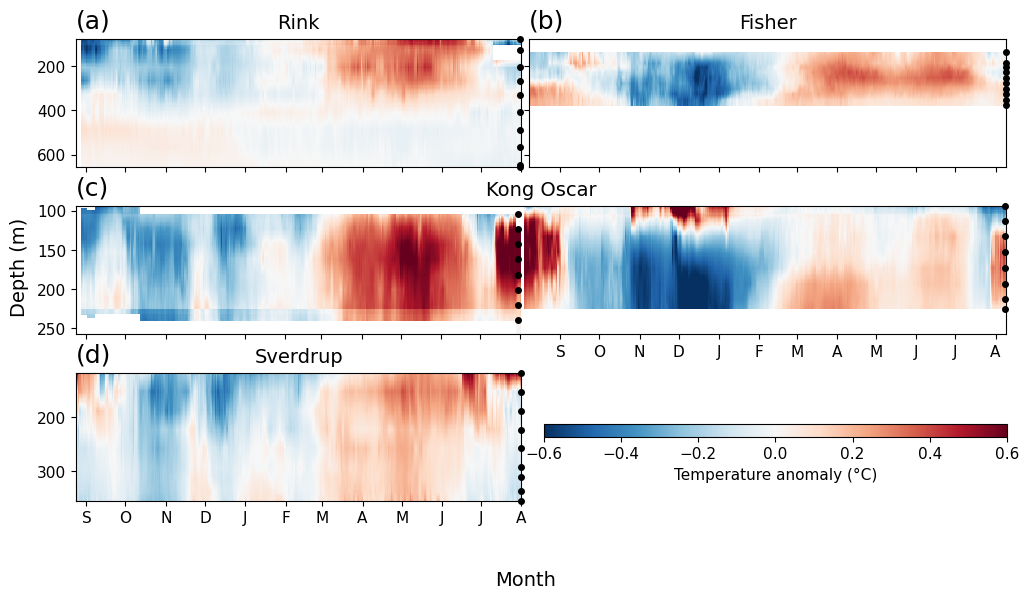

In [122]:
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017,
                         hspace=0.3)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(spec[0]) # two rows, two columns, first cell
ax2 = fig.add_subplot(spec[1]) # two rows, two columns, second cell
# Create third axes, a combination of third and fourth cell
ax3 = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
ax5 = fig.add_subplot(spec[4])

plt.rcParams['font.size'] = '11'

# plot temperature anomaly
for ax,ds in zip([ax1,ax2,ax5],mooring_temp_list):
    delta = ds.temperature - ds.temperature.mean(dim='time',skipna=True)
    delta.plot(ax=ax, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False)
# plot kong oscar
# cbar=KO_temp_delta.plot(ax=ax3, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False) # when each mooring is considered seperately for the mean
cbar=(KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean(dim='time',skipna=True)).plot(ax=ax3, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False)

# set axis limits
ax1.set_ylim(rink_temp_interp_ds.depth.max(),rink_temp_interp_ds.depth.min())
ax2.set_ylim(rink_temp_interp_ds.depth.max(),rink_temp_interp_ds.depth.min())
ax3.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax5.set_ylim(sverdrup_temp_interp_ds.depth.max(),sverdrup_temp_interp_ds.depth.min())

ax1.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))
ax2.set_xlim(fisher_temp_interp_ds.isel(time=3).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax3.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax5.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
ax1.set_title("(a)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax2.set_title("(b)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax3.set_title("(c)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax5.set_title("(d)",loc='left',y=1.3, pad=-20,fontsize = 18)

ax1.set_title("Rink",      loc='center',y=1.3, pad=-20,fontsize = 14)
ax2.set_title("Fisher",    loc='center',y=1.3, pad=-20,fontsize = 14)
ax3.set_title("Kong Oscar",loc='center',y=1.3, pad=-20,fontsize = 14)
ax5.set_title("Sverdrup",  loc='center',y=1.3, pad=-20,fontsize = 14)

# remove y-axis tick labels for subplot 2
ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3,ax5]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.grid()
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months18, [])
ax2.set_xticks(months19, [])
ax3.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax5.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax5,
    width="104%",  # width: 5% of parent_bbox width
    height="10%",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.4, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax5.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Temperature anomaly (°C)', orientation='horizontal')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.07, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

## add sensor depths ------------------------------------------------------------------
ax1.plot(list(itertools.repeat(rink_ds.time[-5].values, len(rink_ds.depth_temperature))), rink_ds.depth_temperature.values,"o", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[-2].values, len(fisher_ds.depth_temperature))), fisher_ds.depth_temperature.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.depth_temperature))), kongoscar19.depth_temperature.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar20.time[-2].values, len(kongoscar20.depth_temperature))), kongoscar20.depth_temperature.values,"o", color='black', markersize=4, clip_on=False)
ax5.plot(list(itertools.repeat(sverdrup_ds.time[-2].values, len(sverdrup_ds.depth_temperature))), sverdrup_ds.depth_temperature.values,"o", color='black', markersize=4, clip_on=False,\
           label='Sensor depth');
# ax5.legend(bbox_to_anchor=(0.75, -0.3, 1, 1));

plt.savefig("../figures/profiles/Mooring_profiles_depth-anomaly-temp.png", bbox_inches='tight', dpi=300)

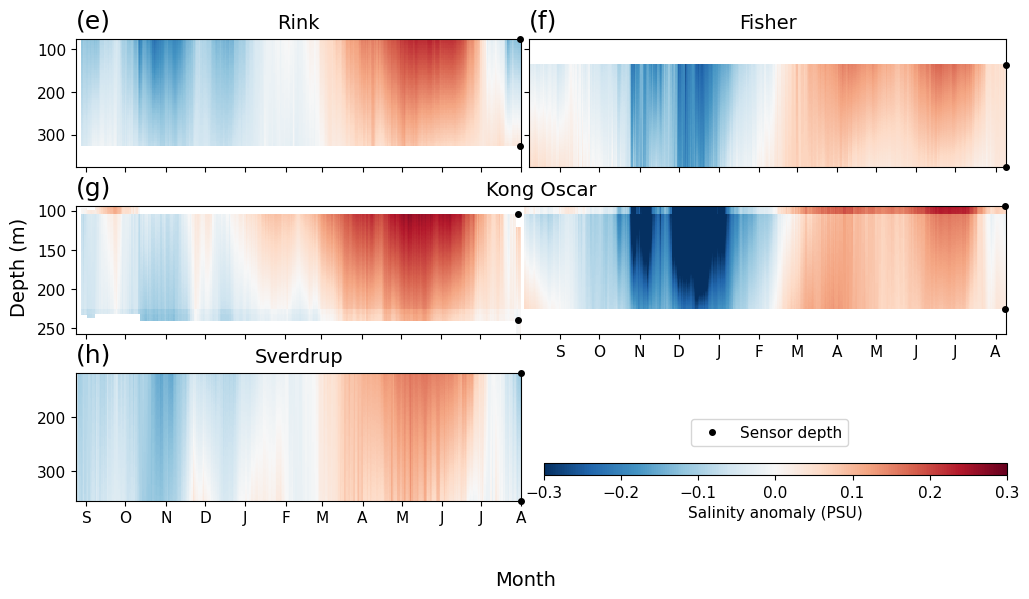

In [121]:
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017,
                         hspace=0.3)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(spec[0]) # two rows, two columns, first cell
ax2 = fig.add_subplot(spec[1]) # two rows, two columns, second cell
# Create third axes, a combination of third and fourth cell
ax3 = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
ax5 = fig.add_subplot(spec[4])

plt.rcParams['font.size'] = '11'

# for all the same temp/salinity scales between all mooring plots:
levels_salt=np.arange(33.3,34.3,0.04)

# plot temperature anomaly
for ax,ds in zip([ax1,ax2,ax5],mooring_salt_list):
    delta = ds.salinity - ds.salinity.mean(dim='time',skipna=True)
    delta.plot(ax=ax, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False)
# plot kong oscar
# cbar=KO_salt_delta.plot(ax=ax3, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False) # when each mooring is considered seperately for the mean
cbar=(KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean(dim='time',skipna=True)).plot(ax=ax3, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False)

# set axis limits
ax1.set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
ax2.set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
ax3.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax5.set_ylim(sverdrup_salt_interp_ds.depth.max(),sverdrup_salt_interp_ds.depth.min())

ax1.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))
ax2.set_xlim(fisher_salt_interp_ds.isel(time=3).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
ax3.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
ax5.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
ax1.set_title("(e)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax2.set_title("(f)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax3.set_title("(g)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax5.set_title("(h)",loc='left',y=1.3, pad=-20,fontsize = 18)

ax1.set_title("Rink",      loc='center',y=1.3, pad=-20,fontsize = 14)
ax2.set_title("Fisher",    loc='center',y=1.3, pad=-20,fontsize = 14)
ax3.set_title("Kong Oscar",loc='center',y=1.3, pad=-20,fontsize = 14)
ax5.set_title("Sverdrup",  loc='center',y=1.3, pad=-20,fontsize = 14)

# remove y-axis tick labels for subplot 2
ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3,ax5]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.grid()
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months18, [])
ax2.set_xticks(months19, [])
ax3.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax5.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax5,
    width="104%",  # width: 5% of parent_bbox width
    height="10%",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.7, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax5.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Salinity anomaly', orientation='horizontal')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.07, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

## add sensor depths ------------------------------------------------------------------
ax1.plot(list(itertools.repeat(rink_ds.time[-5].values, len(rink_ds.depth_CTD))), rink_ds.depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[-2].values, len(fisher_ds.depth_CTD))), fisher_ds.depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.depth_CTD))), kongoscar19.depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar20.time[-2].values, len(kongoscar20.depth_CTD))), kongoscar20.depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax5.plot(list(itertools.repeat(sverdrup_ds.time[-2].values, len(sverdrup_ds.depth_CTD))), sverdrup_ds.depth_CTD.values,"o", color='black', markersize=4, clip_on=False,\
           label='Sensor depth');
ax5.legend(bbox_to_anchor=(0.75, -0.3, 1, 1));

plt.savefig("../figures/profiles/Mooring_profiles_depth-anomaly-salt.png", bbox_inches='tight', dpi=300)